<a href="https://colab.research.google.com/github/Arijit-datascience/Customer-Segmentation/blob/main/customer_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Customer Segmentation

# Importing necessary library 

In [1]:
import pandas as pd
import numpy as np
import math
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
!pip install category_encoders

In [61]:
import datetime as dt
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans

import time

In [4]:
plt.style.use('ggplot')
pd.set_option('display.max_columns', 500)

#Reading Data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Transaction Data...

In [6]:
transaction_df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Raw data.xlsx', sheet_name='Transaction')
transaction_df.drop(columns={'Check'}, inplace=True)
transaction_df.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,1,2,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,2012-12-02
1,2,3,3120,2017-05-21,1.0,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,2014-03-03
2,3,37,402,2017-10-16,0.0,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,1999-07-20
3,4,88,3135,2017-08-31,0.0,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,1998-12-16
4,5,78,787,2017-10-01,1.0,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,2015-08-10


## Demographics data

In [7]:
demog_df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Raw data.xlsx', sheet_name='CustomerDemographic')
demog_df.drop(columns={'default'}, inplace=True)
demog_df.head()

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure
0,34,Jephthah,Bachmann,U,59,1843-12-21,Legal Assistant,IT,Affluent Customer,N,No,20.0
1,66,Anselm,Gawne,Male,46,2002-03-11,Account Executive,Argiculture,High Net Worth,N,No,1.0
2,1888,Sibyl,Scholtz,Female,67,2002-01-26,Food Chemist,Health,Mass Customer,N,Yes,1.0
3,3435,Stevena,Allcock,Female,80,2002-01-15,Senior Editor,NaN,Affluent Customer,N,No,1.0
4,2858,Benedicto,Radki,Male,4,2002-01-09,Recruiting Manager,NaN,Mass Customer,N,Yes,1.0


## Address data

In [8]:
add_df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Raw data.xlsx', sheet_name='CustomerAddress')
add_df.head()

,customer_id,address,postcode,state,country,property_valuation
0,1,060 Morning Avenue,2016,New South Wales,Australia,10
1,2,6 Meadow Vale Court,2153,New South Wales,Australia,10
2,4,0 Holy Cross Court,4211,QLD,Australia,9
3,5,17979 Del Mar Point,2448,New South Wales,Australia,4
4,6,9 Oakridge Court,3216,VIC,Australia,9


## New Customer data

In [9]:
new_cust_df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Raw data.xlsx', sheet_name='NewCustomerList')
new_cust_df.head()


,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,address,postcode,state,country,property_valuation,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Rank,Value
0,Chickie,Brister,Male,86,1957-07-12,General Manager,Manufacturing,Mass Customer,N,Yes,14,45 Shopko Center,4500,QLD,Australia,6,0.61,0.7625,0.953125,0.810156,1,1,1.718750
1,Morly,Genery,Male,69,1970-03-22,Structural Engineer,Property,Mass Customer,N,No,16,14 Mccormick Park,2113,NSW,Australia,11,0.89,0.8900,1.112500,0.945625,1,1,1.718750
2,Ardelis,Forrester,Female,10,1974-08-28,Senior Cost Accountant,Financial Services,Affluent Customer,N,No,10,5 Colorado Crossing,3505,VIC,Australia,5,0.84,0.8400,0.840000,0.840000,1,1,1.718750
3,Lucine,Stutt,Female,64,1979-01-28,Account Representative III,Manufacturing,Affluent Customer,N,Yes,5,207 Annamark Plaza,4814,QLD,Australia,1,0.82,1.0250,1.025000,1.025000,4,4,1.703125
4,Melinda,Hadlee,Female,34,1965-09-21,Financial Analyst,Financial Services,Affluent Customer,N,No,19,115 Montana Place,2093,NSW,Australia,9,0.92,0.9200,1.150000,1.150000,4,4,1.703125


# Data Exploration

In [10]:
print("Unique Customers in transaction data: ",transaction_df.customer_id.nunique())
print('Number of transactions:', transaction_df['transaction_id'].nunique())
print('Number of products bought:', transaction_df['product_id'].nunique())
print('Number of customers:', transaction_df['customer_id'].nunique())
print('Number of brands bought:', transaction_df['brand'].nunique())
print('Number of product line:', transaction_df['product_line'].nunique())
print('Number of product class:', transaction_df['product_class'].nunique())

Unique Customers in transaction data:  3494
Number of transactions: 20000
Number of products bought: 101
Number of customers: 3494
Number of brands bought: 6
Number of product line: 4
Number of product class: 3


In [11]:
#Unique values in categorical columns
for col in ['online_order', 'order_status', 'brand', 'product_line', 'product_class', 'product_size']:
    print(col,": ",transaction_df[col].unique())

online_order :  [ 0.  1. nan]
order_status :  ['Approved' 'Cancelled']
brand :  ['Solex' 'Trek Bicycles' 'OHM Cycles' 'Norco Bicycles' 'Giant Bicycles'
 'WeareA2B' nan]
product_line :  ['Standard' 'Road' 'Mountain' 'Touring' nan]
product_class :  ['medium' 'low' 'high' nan]
product_size :  ['medium' 'large' 'small' nan]


In [12]:
#Checking nulls
transaction_df.isnull().sum()

transaction_id               0
product_id                   0
customer_id                  0
transaction_date             0
online_order               360
order_status                 0
brand                      197
product_line               197
product_class              197
product_size               197
list_price                   0
standard_cost              197
product_first_sold_date    197
dtype: int64

In [13]:
#Removing transactions with no standard cost
transaction_df = transaction_df[~(transaction_df['standard_cost'].isna())]
transaction_df.customer_id.nunique()

3494

In [14]:
#Calculating profit
transaction_df['profit'] = transaction_df['list_price'] - transaction_df['standard_cost']

In [15]:
transaction_df.groupby('order_status')['customer_id'].count()

order_status
Approved     19625
Cancelled      178
Name: customer_id, dtype: int64

In [16]:
#Set profit = 0 when order was cancelled
transaction_df['profit'] = np.where(transaction_df['order_status'] == 'Cancelled', 0, transaction_df['profit'])

In [17]:
transaction_df.describe()

,transaction_id,product_id,customer_id,online_order,list_price,standard_cost,profit
count,19803.000000,19803.000000,19803.000000,19445.000000,19803.000000,19803.000000,19803.000000
mean,9993.979650,45.815937,1739.294955,0.500849,1107.997866,556.046951,546.962785
std,5776.499961,30.569841,1011.946353,0.500012,582.770460,405.955660,494.033915
min,1.000000,0.000000,1.000000,0.000000,12.010000,7.210000,0.000000
25%,4988.500000,18.000000,858.000000,0.000000,575.270000,215.140000,133.780000
50%,9995.000000,45.000000,1738.000000,1.000000,1163.890000,507.580000,445.210000
75%,15000.500000,72.000000,2615.000000,1.000000,1635.300000,795.100000,827.160000
max,20000.000000,100.000000,5034.000000,1.000000,2091.470000,1759.850000,1702.550000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


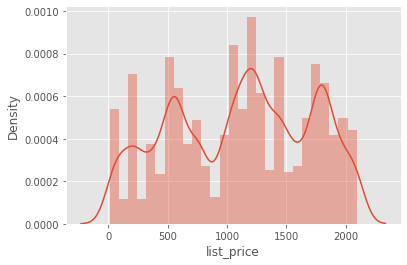

In [18]:
sns.distplot(transaction_df['list_price'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


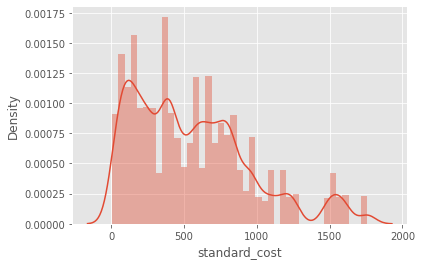

In [19]:
sns.distplot(transaction_df['standard_cost'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


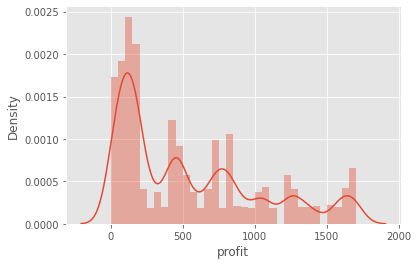

In [20]:
sns.distplot(transaction_df['profit'])

In [21]:
#skewness and kurtosis
print("Skewness: %f" % transaction_df['list_price'].skew())
print("Kurtosis: %f" % transaction_df['list_price'].kurt())

Skewness: -0.126527
Kurtosis: -1.082968


The low skewness proves the data is symmetric and low kurtosis proves less outliers (light tailed) 

In [22]:
customer_df = pd.merge(demog_df, add_df, on='customer_id', how='left')

In [23]:
#Calculating Age
customer_df['age'] = (dt.datetime.now() - customer_df['DOB']).astype('<m8[Y]')

In [24]:
#Cleaning Gender
customer_df.groupby(['gender'])['customer_id'].count()
customer_df['gender'] = np.where(customer_df['gender'].isin(['M', 'Male']), 'Male', 
                                np.where(customer_df['gender'].isin(['F', 'Female', 'Femal']), 'Female','Unknown'))
customer_df['gender'].unique()

array(['Unknown', 'Male', 'Female'], dtype=object)

In [25]:
#Cleaning State
customer_df.groupby(['state'])['customer_id'].count()
customer_df['state'] = np.where(customer_df['state'].isin(['NSW', 'New South Wales']), 'NSW', 
                                np.where(customer_df['state'].isin(['VIC', 'Victoria']), 'VIC','QLD'))
customer_df['state'].unique()

array(['QLD', 'NSW', 'VIC'], dtype=object)

In [26]:
#Adding Profit and Purchase amount
profit_df = transaction_df.groupby(['customer_id'], as_index=False).agg({'profit':'sum', 'list_price':'sum'})

customer_df = pd.merge(customer_df, profit_df, on='customer_id')

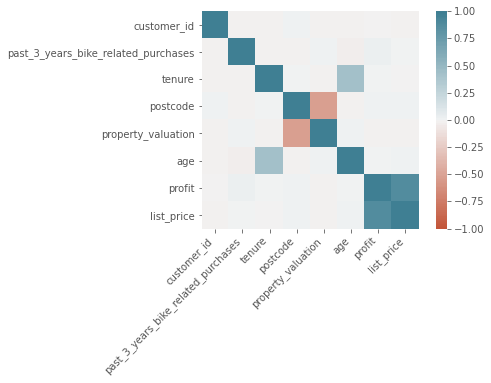

In [27]:
#Calculating Correlations
corr = customer_df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

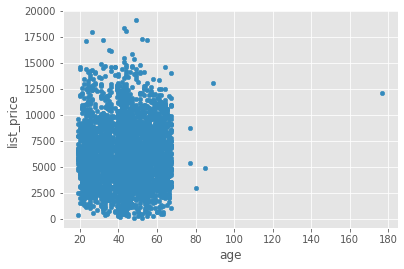

In [28]:
var = 'age'
data = pd.concat([customer_df['list_price'], customer_df[var]], axis=1)
data.plot.scatter(x=var, y='list_price')

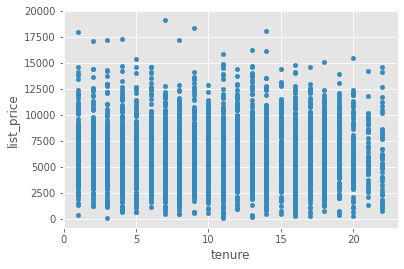

In [29]:
var = 'tenure'
data = pd.concat([customer_df['list_price'], customer_df[var]], axis=1)
data.plot.scatter(x=var, y='list_price')

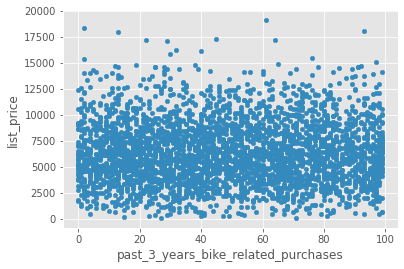

In [30]:
var = 'past_3_years_bike_related_purchases'
data = pd.concat([customer_df['list_price'], customer_df[var]], axis=1)
data.plot.scatter(x=var, y='list_price')

The above distribution shows the list price is very uniformly distributed across various parameters.
No pattern found between them

# RFM Analysis
RFM (Recency, Frequency, Monetary) analysis is a customer segmentation technique that uses past purchase behaviour to dive customers into groups.


Recency: Days since last purchase

Frequency: Total number of purchases

Monetary Value: Total money this customer spent

In [31]:
#Recency of customer

recency_df = transaction_df.groupby(['customer_id'], as_index=False)['transaction_date'].max()
recency_df.columns = ['customer_id', 'Last_Purchase_date']
recency_df.head()

,customer_id,Last_Purchase_date
0,1,2017-12-23
1,2,2017-08-24
2,3,2017-09-19
3,4,2017-06-18
4,5,2017-12-14


In [32]:
print('Min date:', transaction_df['transaction_date'].min(), 'Max date:',transaction_df['transaction_date'].max())

now = dt.date(2018, 1, 1)
recency_df['Last_Purchase_date'] = pd.DatetimeIndex(recency_df.Last_Purchase_date).date
recency_df['recency'] = recency_df.Last_Purchase_date.apply(lambda x: (now - x).days)
recency_df.drop(columns={'Last_Purchase_date'}, inplace=True)
recency_df.head()

Min date: 2017-01-01 00:00:00 Max date: 2017-12-30 00:00:00


,customer_id,recency
0,1,9
1,2,130
2,3,104
3,4,197
4,5,18


In [33]:
# Frequency calculation
frequency_df = transaction_df.copy()
frequency_df.drop_duplicates(subset=['customer_id', 'transaction_id'], keep='first', inplace=True)

frequency_df = frequency_df.groupby(['customer_id'], as_index=False)['transaction_id'].count()
frequency_df.columns = ['customer_id', 'frequency']
frequency_df.head()

,customer_id,frequency
0,1,11
1,2,3
2,3,8
3,4,2
4,5,6


In [34]:
#Monetary Value

monetary_df = transaction_df.groupby(['customer_id'], as_index=False)['list_price'].sum()
monetary_df.columns = ['customer_id', 'monetary']
monetary_df.sort_values(by='monetary')

,customer_id,monetary
3284,3292,60.34
2527,2532,71.49
2269,2274,142.98
3183,3189,200.70
2418,2423,202.62
...,...,...
2782,2788,17258.94
938,941,17898.46
1593,1597,18052.68
1126,1129,18349.27


In [35]:
rf = pd.merge(recency_df, frequency_df, on='customer_id')
rfm = pd.merge(rf, monetary_df, on='customer_id')
rfm.head()

,customer_id,recency,frequency,monetary
0,1,9,11,9084.45
1,2,130,3,4149.07
2,3,104,8,9888.23
3,4,197,2,1047.72
4,5,18,6,5903.20


In [36]:
quantiles = rfm.quantile(q=[0.25, 0.5, 0.75])
quantiles
quantiles.to_dict()

{'customer_id': {0.25: 876.25, 0.5: 1750.5, 0.75: 2624.75},
 'frequency': {0.25: 4.0, 0.5: 6.0, 0.75: 7.0},
 'monetary': {0.25: 4153.662499999999, 0.5: 5991.375, 0.75: 8135.42},
 'recency': {0.25: 19.0, 0.5: 46.0, 0.75: 88.0}}

In [37]:
def R_score(x, p, d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.5]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1

def FM_score(x, p, d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.5]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4

In [38]:
rfm['R_Quartile'] = rfm['recency'].apply(R_score, args=('recency', quantiles,))
rfm['F_Quartile'] = rfm['frequency'].apply(FM_score, args=('frequency', quantiles,))
rfm['M_Quartile'] = rfm['monetary'].apply(FM_score, args=('monetary', quantiles,))
rfm.head()

,customer_id,recency,frequency,monetary,R_Quartile,F_Quartile,M_Quartile
0,1,9,11,9084.45,4,4,4
1,2,130,3,4149.07,1,1,1
2,3,104,8,9888.23,1,4,4
3,4,197,2,1047.72,1,1,1
4,5,18,6,5903.20,4,2,2


In [39]:
rfm['RFMScore'] = rfm['R_Quartile'].map(str) + rfm['F_Quartile'].map(str) + rfm['M_Quartile'].map(str)
rfm = rfm.reset_index(drop=True)
rfm.head()

,customer_id,recency,frequency,monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore
0,1,9,11,9084.45,4,4,4,444
1,2,130,3,4149.07,1,1,1,111
2,3,104,8,9888.23,1,4,4,144
3,4,197,2,1047.72,1,1,1,111
4,5,18,6,5903.20,4,2,2,422


In [40]:
print('Total customers:', rfm.customer_id.count())
print('Best customers:', rfm[rfm['RFMScore'] == '444']['customer_id'].count())
print('Loyal customers:', rfm[rfm['F_Quartile'] == 4]['customer_id'].count())
print('Lost customers:', rfm[rfm['R_Quartile'] == 1]['customer_id'].count())

Total customers: 3494
Best customers: 210
Loyal customers: 712
Lost customers: 864


# Customer Life Cycle Value Analysis

In [41]:
mm_scalar = MinMaxScaler()

rfm_scaled = rfm[['frequency','monetary']]
rfm_scaled = pd.DataFrame(mm_scalar.fit_transform(rfm_scaled), columns=['frequency_mm','monetary_mm'])

rfm_inv_scaled = rfm[['recency']]
rfm_inv_scaled = pd.DataFrame(mm_scalar.fit_transform(rfm_inv_scaled), columns=['recency_mm'])

rfm = pd.concat([rfm, rfm_scaled, rfm_inv_scaled], axis=1)

rfm.head()

,customer_id,recency,frequency,monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,frequency_mm,monetary_mm,recency_mm
0,1,9,11,9084.45,4,4,4,444,0.769231,0.474679,0.019830
1,2,130,3,4149.07,1,1,1,111,0.153846,0.215072,0.362606
2,3,104,8,9888.23,1,4,4,144,0.538462,0.516959,0.288952
3,4,197,2,1047.72,1,1,1,111,0.076923,0.051937,0.552408
4,5,18,6,5903.20,4,2,2,422,0.384615,0.307341,0.045326


## Life time value = Average Value of Sale x Number of transactions x Retention Time Period


In [42]:
avg_sales_value = transaction_df.groupby(['customer_id'], as_index=False)['list_price'].mean()
avg_sales_value.columns = ['customer_id', 'avg_value_of_sale']
avg_sales_value_mm = pd.DataFrame(mm_scalar.fit_transform(avg_sales_value[['avg_value_of_sale']]), columns=['avg_value_of_sale_mm'])
avg_sales_value = pd.concat([avg_sales_value, avg_sales_value_mm], axis=1)

rfm = pd.merge(rfm, avg_sales_value, on='customer_id')

rfm['lifetime_value'] = rfm.avg_value_of_sale_mm * rfm.frequency_mm * rfm.recency_mm

## Customer Life Cycle Value = Life time value * Profit Margin

In [43]:
rfm = pd.merge(rfm, profit_df, on='customer_id')

rfm['customer_lifetime_value'] = rfm['lifetime_value'] * rfm['profit']
rfm.head(10)

,customer_id,recency,frequency,monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,frequency_mm,monetary_mm,recency_mm,avg_value_of_sale,avg_value_of_sale_mm,lifetime_value,profit,list_price,customer_lifetime_value
0,1,9,11,9084.45,4,4,4,444,0.769231,0.474679,0.019830,825.859091,0.376893,0.005749,3018.09,9084.45,17.351238
1,2,130,3,4149.07,1,1,1,111,0.153846,0.215072,0.362606,1383.023333,0.651206,0.036328,2226.26,4149.07,80.875309
2,3,104,8,9888.23,1,4,4,144,0.538462,0.516959,0.288952,1236.028750,0.578835,0.090061,3362.81,9888.23,302.856658
3,4,197,2,1047.72,1,1,1,111,0.076923,0.051937,0.552408,523.860000,0.228208,0.009697,220.57,1047.72,2.138916
4,5,18,6,5903.20,4,2,2,422,0.384615,0.307341,0.045326,983.866667,0.454686,0.007927,2394.94,5903.20,18.983587
5,6,66,5,5931.69,2,2,2,222,0.307692,0.308840,0.181303,1186.338000,0.554370,0.030926,3946.55,5931.69,122.050459
6,7,255,3,995.38,1,1,1,111,0.153846,0.049184,0.716714,331.793333,0.133646,0.014736,220.11,995.38,3.243618
7,8,24,10,12024.76,3,4,4,344,0.692308,0.629343,0.062323,1202.476000,0.562316,0.024262,7066.94,12024.76,171.458349
8,9,80,6,5357.55,2,2,2,222,0.384615,0.278640,0.220963,892.925000,0.409912,0.034837,2353.11,5357.55,81.974663
9,10,45,5,5003.75,3,2,2,322,0.307692,0.260029,0.121813,1000.750000,0.462998,0.017354,3358.28,5003.75,58.278291


In [44]:
rfm_segmentation = rfm[['customer_id', 'R_Quartile', 'F_Quartile', 'M_Quartile', 'profit', 'list_price', 'customer_lifetime_value']]

# Visualise results of RFM and CLV analysis with customer data

In [45]:
customer_df = pd.merge(customer_df, rfm[['customer_id', 'R_Quartile', 'F_Quartile', 'M_Quartile', 'RFMScore', 'customer_lifetime_value']], on='customer_id')

In [46]:
agg = customer_df.groupby('RFMScore')['customer_id'].count().reset_index()
agg = agg[agg['customer_id'] >= 100]
rfm_list = tuple(agg['RFMScore'])
rfm_list

('111',
 '112',
 '123',
 '211',
 '222',
 '223',
 '244',
 '311',
 '322',
 '323',
 '344',
 '411',
 '422',
 '423',
 '444')

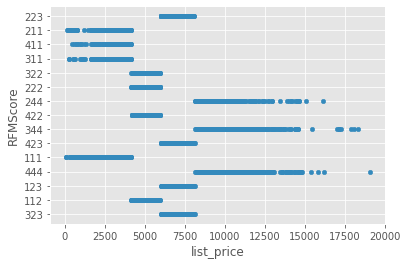

In [47]:
var = 'RFMScore'
data = customer_df[customer_df['RFMScore'].isin(rfm_list)][[var, 'list_price']]
data.plot.scatter(y=var, x='list_price')

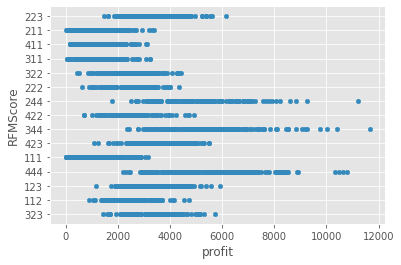

In [48]:
var = 'RFMScore'
data = customer_df[customer_df['RFMScore'].isin(rfm_list)][[var, 'profit']]
data.plot.scatter(y=var, x='profit')

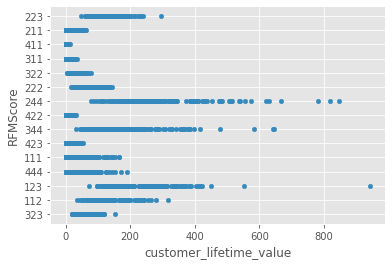

In [49]:
var = 'RFMScore'
data = customer_df[customer_df['RFMScore'].isin(rfm_list)][[var, 'customer_lifetime_value']]
data.plot.scatter(y=var, x='customer_lifetime_value')

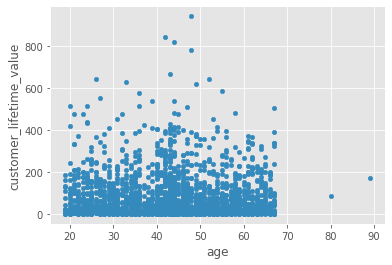

In [50]:
var = 'age'
data = customer_df[customer_df['RFMScore'].isin(rfm_list)][[var, 'customer_lifetime_value']]
data.plot.scatter(x=var, y='customer_lifetime_value')

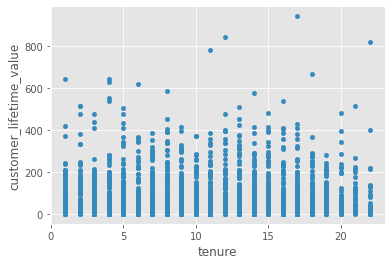

In [51]:
var = 'tenure'
data = customer_df[customer_df['RFMScore'].isin(rfm_list)][[var, 'customer_lifetime_value']]
data.plot.scatter(x=var, y='customer_lifetime_value')

All explorations shows no relation between the demographics data

# K-means Clustering

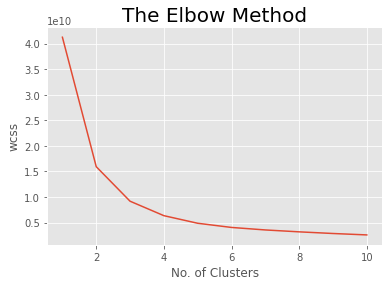

In [52]:
x = rfm_segmentation.iloc[:,1:]

wcss = []

for i in range(1, 11):
    km = KMeans(n_clusters = i, init='k-means++', max_iter = 300, n_init = 10, random_state=1)
    km.fit(x)
    wcss.append(km.inertia_)
    
plt.plot(range(1,11), wcss)
plt.title('The Elbow Method', fontsize=20)
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')
plt.show()

From the elbow chart we will select 5 as optimum no. of clusters. We may also consider 4 as elbow point

In [53]:
km = KMeans(n_clusters = 5, init='k-means++', max_iter = 500, n_init = 10, random_state = 1)
y_means = km.fit_predict(x)

y_label = pd.DataFrame(y_means)
y_label.columns = ['cluster']
y_label['cluster'] += 1

customer_df1 = pd.concat([customer_df, y_label], axis=1)

In [54]:
print(customer_df1.groupby(['cluster'])['customer_id'].count())

cluster
1    604
2    694
3    966
4    254
5    975
Name: customer_id, dtype: int64


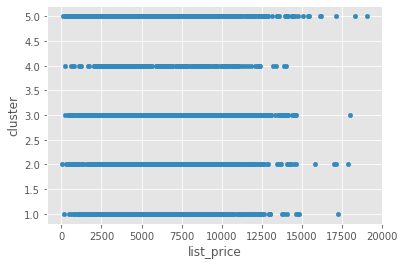

In [55]:
var = 'cluster'
data = pd.concat([customer_df1['list_price'], customer_df1[var]], axis=1)
data.plot.scatter(y=var, x='list_price')

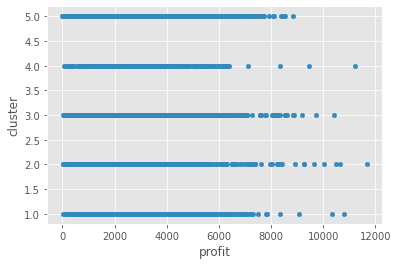

In [56]:
var = 'cluster'
data = pd.concat([customer_df1['profit'], customer_df1[var]], axis=1)
data.plot.scatter(y=var, x='profit')

In [57]:
customer_df1.groupby(['cluster']).agg({'profit':'mean', 'customer_lifetime_value':'mean'})

,profit,customer_lifetime_value
cluster,,
1,3091.134735,97.761250
2,3070.381153,98.610787
3,3074.338406,88.782000
4,3225.056417,111.623696
5,3122.430174,90.607622


# Data Preprocessing

In [58]:
customer_df1['age'] = customer_df1['age'].fillna(round(customer_df1['age'].mean(), 0))
customer_df1['tenure'] = customer_df1['tenure'].fillna(round(customer_df1['tenure'].mean(), 0))

In [59]:
customer_df1['past3Y_bike'] = pd.qcut(customer_df1['past_3_years_bike_related_purchases'],
                              q=[0, .2, .4, .6, .8, 1], labels=['0-19', '20-38', '39-58', '59-78', '79-99'])

customer_df1['tenure_bucket'] = pd.qcut(customer_df1['tenure'],
                              q=[0, .2, .4, .6, .8, 1], labels=['1-5', '6-9', '10-12', '13-16', '17-22'])


customer_df1['property_val'] = pd.qcut(customer_df1['property_valuation'],
                              q=[0, .2, .4, .6, .8, 1], labels=['1-5', '6-7', '8-9', '10-10', '11-12'])

customer_df1['age_bucket'] = pd.qcut(customer_df1['age'],
                              q=[0, .2, .4, .6, .8, 1], labels=['0-31', '32-41', '42-46', '47-55', '56+'])

In [60]:
customer_df1['job_title'] = customer_df1['job_title'].fillna('Unknown')
customer_df1['job_industry_category'] = customer_df1['job_industry_category'].fillna('Unknown')

customer_df1[['age_bucket','gender','job_title','job_industry_category','wealth_segment','owns_car','postcode','state','past3Y_bike','tenure_bucket','property_val']] = customer_df1[['age_bucket','gender','job_title','job_industry_category','wealth_segment','owns_car','postcode','state','past3Y_bike','tenure_bucket','property_val']].astype(str)

Label Encoding the categorical variables

In [63]:
le = LabelEncoder()

customer_df1['age_bucket_cat'] = le.fit_transform(customer_df1['age_bucket'])
customer_df1['gender_cat'] = le.fit_transform(customer_df1['gender'])
customer_df1['job_title_cat'] = le.fit_transform(customer_df1['job_title'])
customer_df1['job_industry_category_cat'] = le.fit_transform(customer_df1['job_industry_category'])
customer_df1['wealth_segment_cat'] = le.fit_transform(customer_df1['wealth_segment'])
customer_df1['owns_car_cat'] = le.fit_transform(customer_df1['owns_car'])
customer_df1['postcode_cat'] = le.fit_transform(customer_df1['postcode'])
customer_df1['state_cat'] = le.fit_transform(customer_df1['state'])
customer_df1['past3Y_bike_cat'] = le.fit_transform(customer_df1['past3Y_bike'])
customer_df1['tenure_bucket_cat'] = le.fit_transform(customer_df1['tenure_bucket'])
customer_df1['property_val_cat'] = le.fit_transform(customer_df1['property_val'])

In [64]:
customer_df1['segment'] = customer_df1['age_bucket'].map(str) + '_' + customer_df1['job_title'].map(str) + '_' + customer_df1['owns_car'].map(str) + '_' + customer_df1['postcode'].map(str) + '_' + customer_df1['past3Y_bike'].map(str) + '_' + customer_df1['tenure_bucket'].map(str) + '_' + customer_df1['property_val'].map(str)
customer_df1['segment'].nunique()

3494

This shows the discreteness of the data.
All records of data are different and has no correlation between them.
Such data cannot be trained using ML models unless we create a separate tree for each record.  

# Rule Based Collaborative Filtering

In [65]:
customer_df1['seg_map1'] = customer_df1['age_bucket_cat'].map(str) + "_" + customer_df1['gender_cat'].map(str) + "_" + customer_df1['job_title_cat'].map(str) + "_" + customer_df1['job_industry_category_cat'].map(str) + "_" + customer_df1['wealth_segment_cat'].map(str) + "_" + customer_df1['owns_car_cat'].map(str) + "_" + customer_df1['state_cat'].map(str) + "_" + customer_df1['past3Y_bike_cat'].map(str) + "_" + customer_df1['tenure_bucket_cat'].map(str) + "_" + customer_df1['property_val_cat'].map(str)
customer_df1['seg_map2'] = customer_df1['age_bucket_cat'].map(str) + "_" + customer_df1['wealth_segment_cat'].map(str) + "_" + customer_df1['owns_car_cat'].map(str) + "_" + customer_df1['state_cat'].map(str) + "_" + customer_df1['past3Y_bike_cat'].map(str) + "_" + customer_df1['tenure_bucket_cat'].map(str) + "_" + customer_df1['property_val_cat'].map(str)
customer_df1['seg_map3'] = customer_df1['age_bucket_cat'].map(str) + "_" + customer_df1['wealth_segment_cat'].map(str) + "_" + customer_df1['state_cat'].map(str) + "_" + customer_df1['past3Y_bike_cat'].map(str) + "_" + customer_df1['tenure_bucket_cat'].map(str) + "_" + customer_df1['property_val_cat'].map(str)
customer_df1['seg_map4'] = customer_df1['age_bucket_cat'].map(str) + "_" + customer_df1['wealth_segment_cat'].map(str) + "_" + customer_df1['past3Y_bike_cat'].map(str) + "_" + customer_df1['tenure_bucket_cat'].map(str) + "_" + customer_df1['property_val_cat'].map(str)
customer_df1['seg_map5'] = customer_df1['age_bucket_cat'].map(str) + "_" + customer_df1['past3Y_bike_cat'].map(str) + "_" + customer_df1['tenure_bucket_cat'].map(str) + "_" + customer_df1['property_val_cat'].map(str)
customer_df1['seg_map6'] = customer_df1['age_bucket_cat'].map(str) + "_" + customer_df1['past3Y_bike_cat'].map(str) + "_" + customer_df1['tenure_bucket_cat'].map(str)
customer_df1['seg_map7'] = customer_df1['age_bucket_cat'].map(str) + "_" + customer_df1['state_cat'].map(str) + "_" + customer_df1['past3Y_bike_cat'].map(str) + "_" + customer_df1['tenure_bucket_cat'].map(str) + "_" + customer_df1['property_val_cat'].map(str)
customer_df1['seg_map8'] = customer_df1['state_cat'].map(str) + "_" + customer_df1['past3Y_bike_cat'].map(str) + "_" + customer_df1['tenure_bucket_cat'].map(str) + "_" + customer_df1['property_val_cat'].map(str)
customer_df1['seg_map9'] = customer_df1['past3Y_bike_cat'].map(str) + "_" + customer_df1['property_val_cat'].map(str)


Preprocessing Validation data (New Customer Data)

In [66]:
new_cust_df = new_cust_df[['first_name','last_name','gender', 'past_3_years_bike_related_purchases', 'DOB', 'job_title', 'job_industry_category', 'wealth_segment', 'owns_car', 'tenure', 'postcode', 'state', 'property_valuation']]

new_cust_df['age'] = (dt.datetime.now() - new_cust_df['DOB']).astype('<m8[Y]')
#Cleaning Gender
new_cust_df['gender'] = np.where(new_cust_df['gender'].isin(['M', 'Male']), 'Male', 
                                np.where(new_cust_df['gender'].isin(['F', 'Female', 'Femal']), 'Female','Unknown'))
new_cust_df['gender'].unique()

#Cleaning State
new_cust_df['state'] = np.where(new_cust_df['state'].isin(['NSW', 'New South Wales']), 'NSW', 
                                np.where(new_cust_df['state'].isin(['VIC', 'Victoria']), 'VIC','QLD'))
new_cust_df['state'].unique()

new_cust_df['age'] = new_cust_df['age'].fillna(round(new_cust_df['age'].mean(), 0))
new_cust_df['tenure'] = new_cust_df['tenure'].fillna(round(new_cust_df['tenure'].mean(), 0))

In [67]:
new_cust_df['past3Y_bike'] = np.where(new_cust_df['past_3_years_bike_related_purchases'] <= 19, '0-19',
                              	      np.where((new_cust_df['past_3_years_bike_related_purchases'] >= 20) & (new_cust_df['past_3_years_bike_related_purchases'] <= 38), '20-38',
                              	      np.where((new_cust_df['past_3_years_bike_related_purchases'] >= 39) & (new_cust_df['past_3_years_bike_related_purchases'] <= 58), '39-58',
                              	      np.where((new_cust_df['past_3_years_bike_related_purchases'] >= 59) & (new_cust_df['past_3_years_bike_related_purchases'] <= 78), '59-78',
                              	      np.where((new_cust_df['past_3_years_bike_related_purchases'] >= 79), '79-99', 0)))))

new_cust_df['tenure_bucket'] = np.where(new_cust_df['tenure'] <= 5, '1-5',
                              	      np.where((new_cust_df['tenure'] >= 6) & (new_cust_df['tenure'] <= 9), '6-9',
                              	      np.where((new_cust_df['tenure'] >= 10) & (new_cust_df['tenure'] <= 12), '10-12',
                              	      np.where((new_cust_df['tenure'] >= 13) & (new_cust_df['tenure'] <= 16), '13-16',
                              	      np.where((new_cust_df['tenure'] >= 17), '17-22', 0)))))

new_cust_df['property_val'] = np.where(new_cust_df['property_valuation'] <= 5, '1-5',
                              	      np.where((new_cust_df['property_valuation'] >= 6) & (new_cust_df['property_valuation'] <= 7), '6-7',
                              	      np.where((new_cust_df['property_valuation'] >= 8) & (new_cust_df['property_valuation'] <= 9), '8-9',
                              	      np.where((new_cust_df['property_valuation'] == 10), '10-10',
                              	      np.where((new_cust_df['property_valuation'] >= 11), '11-12', 0)))))

new_cust_df['age_bucket'] = np.where(new_cust_df['age'] <= 31, '1-31',
                              	      np.where((new_cust_df['age'] >= 32) & (new_cust_df['age'] <= 41), '32-41',
                              	      np.where((new_cust_df['age'] >= 42) & (new_cust_df['age'] <= 46), '42-46',
                              	      np.where((new_cust_df['age'] >= 47) & (new_cust_df['age'] <= 55), '47-55',
                              	      np.where((new_cust_df['age'] >= 56), '56+', 0)))))

new_cust_df['job_title'] = new_cust_df['job_title'].fillna('Unknown')
new_cust_df['job_industry_category'] = new_cust_df['job_industry_category'].fillna('Unknown')

In [68]:
new_cust_df['age_bucket_cat'] = le.fit_transform(new_cust_df['age_bucket'])
new_cust_df['gender_cat'] = le.fit_transform(new_cust_df['gender'])
new_cust_df['job_title_cat'] = le.fit_transform(new_cust_df['job_title'])
new_cust_df['job_industry_category_cat'] = le.fit_transform(new_cust_df['job_industry_category'])
new_cust_df['wealth_segment_cat'] = le.fit_transform(new_cust_df['wealth_segment'])
new_cust_df['owns_car_cat'] = le.fit_transform(new_cust_df['owns_car'])
new_cust_df['postcode_cat'] = le.fit_transform(new_cust_df['postcode'])
new_cust_df['state_cat'] = le.fit_transform(new_cust_df['state'])
new_cust_df['past3Y_bike_cat'] = le.fit_transform(new_cust_df['past3Y_bike'])
new_cust_df['tenure_bucket_cat'] = le.fit_transform(new_cust_df['tenure_bucket'])
new_cust_df['property_val_cat'] = le.fit_transform(new_cust_df['property_val'])

In [69]:
new_cust_df[['age_bucket','gender','job_title','job_industry_category','wealth_segment','owns_car','postcode','state','past3Y_bike','tenure_bucket','property_val']] = new_cust_df[['age_bucket','gender','job_title','job_industry_category','wealth_segment','owns_car','postcode','state','past3Y_bike','tenure_bucket','property_val']].astype(str)

In [70]:
new_cust_df['seg_map1'] = new_cust_df['age_bucket_cat'].map(str) + "_" + new_cust_df['gender_cat'].map(str) + "_" + new_cust_df['job_title_cat'].map(str) + "_" + new_cust_df['job_industry_category_cat'].map(str) + "_" + new_cust_df['wealth_segment_cat'].map(str) + "_" + new_cust_df['owns_car_cat'].map(str) + "_" + new_cust_df['state_cat'].map(str) + "_" + new_cust_df['past3Y_bike_cat'].map(str) + "_" + new_cust_df['tenure_bucket_cat'].map(str) + "_" + new_cust_df['property_val_cat'].map(str)
new_cust_df['seg_map2'] = new_cust_df['age_bucket_cat'].map(str) + "_" + new_cust_df['wealth_segment_cat'].map(str) + "_" + new_cust_df['owns_car_cat'].map(str) + "_" + new_cust_df['state_cat'].map(str) + "_" + new_cust_df['past3Y_bike_cat'].map(str) + "_" + new_cust_df['tenure_bucket_cat'].map(str) + "_" + new_cust_df['property_val_cat'].map(str)
new_cust_df['seg_map3'] = new_cust_df['age_bucket_cat'].map(str) + "_" + new_cust_df['wealth_segment_cat'].map(str) + "_" + new_cust_df['state_cat'].map(str) + "_" + new_cust_df['past3Y_bike_cat'].map(str) + "_" + new_cust_df['tenure_bucket_cat'].map(str) + "_" + new_cust_df['property_val_cat'].map(str)
new_cust_df['seg_map4'] = new_cust_df['age_bucket_cat'].map(str) + "_" + new_cust_df['wealth_segment_cat'].map(str) + "_" + new_cust_df['past3Y_bike_cat'].map(str) + "_" + new_cust_df['tenure_bucket_cat'].map(str) + "_" + new_cust_df['property_val_cat'].map(str)
new_cust_df['seg_map5'] = new_cust_df['age_bucket_cat'].map(str) + "_" + new_cust_df['past3Y_bike_cat'].map(str) + "_" + new_cust_df['tenure_bucket_cat'].map(str) + "_" + new_cust_df['property_val_cat'].map(str)
new_cust_df['seg_map6'] = new_cust_df['age_bucket_cat'].map(str) + "_" + new_cust_df['past3Y_bike_cat'].map(str) + "_" + new_cust_df['tenure_bucket_cat'].map(str)
new_cust_df['seg_map7'] = new_cust_df['age_bucket_cat'].map(str) + "_" + new_cust_df['state_cat'].map(str) + "_" + new_cust_df['past3Y_bike_cat'].map(str) + "_" + new_cust_df['tenure_bucket_cat'].map(str) + "_" + new_cust_df['property_val_cat'].map(str)
new_cust_df['seg_map8'] = new_cust_df['state_cat'].map(str) + "_" + new_cust_df['past3Y_bike_cat'].map(str) + "_" + new_cust_df['tenure_bucket_cat'].map(str) + "_" + new_cust_df['property_val_cat'].map(str)
new_cust_df['seg_map9'] = new_cust_df['past3Y_bike_cat'].map(str) + "_" + new_cust_df['property_val_cat'].map(str)

In [71]:
new_cust_cluster = pd.DataFrame()
seg_items = ['seg_map1', 'seg_map2', 'seg_map3', 'seg_map4', 'seg_map5', 'seg_map6', 'seg_map7', 'seg_map8', 'seg_map9']

In [72]:
for k in seg_items: 
    #Seg1
    customer_cluster = customer_df1[[k, 'cluster', 'customer_id']].reset_index(drop=True)
    customer_cluster.sort_values(by=[k, 'cluster'], inplace=True)
    customer_cluster = customer_cluster.groupby([k,'cluster'], as_index=False)['customer_id'].count()
    customer_cluster.rename(columns={'customer_id':'cnt'}, inplace=True)
    customer_cluster['rank'] = customer_cluster.groupby([k,'cluster'])['cnt'].rank(ascending=0)
    customer_cluster = customer_cluster[customer_cluster['rank'] == 1].reset_index(drop=True)
  
    new_cust_df = pd.merge(new_cust_df,customer_cluster[[k, 'cluster']], on=k, how='left')
    
    temp = new_cust_df[~(new_cust_df['cluster'].isna())].reset_index(drop=True)
    new_cust_df = new_cust_df[new_cust_df['cluster'].isna()].reset_index(drop=True)
    new_cust_df.drop(columns={'cluster'}, inplace=True)
    
    new_cust_cluster = pd.concat([new_cust_cluster, temp], axis=0)

In [73]:
new_cust_cluster = new_cust_cluster.sort_values(by=['first_name','last_name', 'cluster'], ascending=[True, True, False])
new_cust_cluster = new_cust_cluster.drop_duplicates(subset=['first_name','last_name', 'age'], keep='first')

In [74]:
new_cust_cluster.groupby('cluster')['first_name'].count()

cluster
1.0    123
2.0    143
3.0    252
4.0     63
5.0    419
Name: first_name, dtype: int64